In [1]:
import os
import pickle
import copy
import random
import logging
import argparse

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
from collections import defaultdict
from sklearn.manifold import TSNE

from timeit import default_timer as timer
from datetime import timedelta

from blocks import VAE
from dataset import MorphologyDatasetTask3, Vocabulary

from blocks_main import initialize_model, initialize_dataloader

In [2]:
def plot_TSNE(model, test_loader, hide_axis=True):

    model.eval()
    z_list = None
    it_sup = iter(test_loader)
    i      = 0

    while True:
        try:
            sample_batched_sup = next(it_sup)
        except StopIteration:
            break

        x_t_sup = sample_batched_sup['target_form'].to(device)
        x_t_sup = torch.transpose(x_t_sup, 0, 1)

        outputs, mu, logvar = model(x_t_sup)

        z = model.reparameterize(mu, logvar)
        
        if i == 0:
            z_list = z.detach().cpu().numpy()
        else:
            z_list = np.concatenate((z_list, z.detach().cpu().numpy()), axis=0)
        
        i += 1

    print("Num test points = {}".format(str(i)))
    X_reduced = TSNE(n_components=2, random_state=0).fit_transform(z_list)

    plt.figure(figsize=(8, 6))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], marker='o', edgecolor='none', cmap=plt.cm.get_cmap('tab10', 10))
#     plt.colorbar(ticks=range(10))
    axes = plt.gca()
    plt.grid(linestyle='--', linewidth=0.5)

    if hide_axis:
        plt.axis('off')
    plt.show()

### Word VAE 

In [3]:
language = 'turkish'
model_id = '10'

device         = torch.device('cpu')
checkpoint     = torch.load('../models/vae_{}-{}/model.pt'.format(language, model_id), map_location=device)

config         = checkpoint['config']
vocab          = checkpoint['vocab']

test_loader, d = initialize_dataloader(run_type='test', language=config['language'], task='sup',
                                       vocab=vocab, batch_size=1, shuffle=True)
idx_2_char     = d.idx_2_char

model          = initialize_model(config)
model.load_state_dict(checkpoint['model_state_dict'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

Num test points = 1600


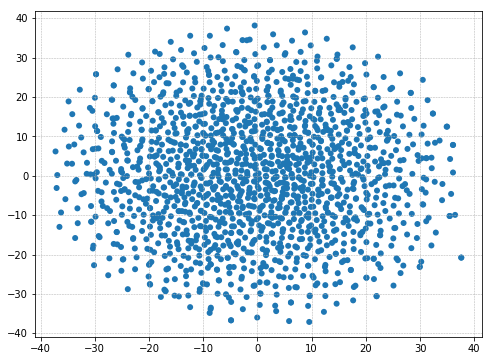

In [4]:
plot_TSNE(model, test_loader, hide_axis=False)